# Clustering por UMAP y PCA

**Última edición:** 31 de Mayo del 2023

El presente notebook propone un algoritmo no supervisado para agrupar (potencialmente) las 13 enfermedades musculoesqueléticas a partir del perfil de expresión génica de los 121 pacientes.

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse

In [206]:
!wget --no-check-certificate -q 'https://docs.google.com/uc?export=download&id=1Ijo8ZQ9qewOJIAWJPFsb95D3HST8Ab0N' -O gen.csv
!wget --no-check-certificate -q 'https://docs.google.com/uc?export=download&id=1XFNxgBRccBYN2OLYrjMfHI-D5ErnaVeN' -O target.csv

In [208]:
gen = pd.read_csv('gen.csv')
gen.rename(columns = {'Unnamed: 0': 'Pacientes'}, inplace = True)
gen

,Pacientes,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM74239,10.612030,5.748065,8.916975,11.571986,7.698052,10.045446,8.467890,8.268186,7.285383,...,7.619677,8.864354,15.862026,15.918815,5.891305,5.204751,6.775879,5.039032,5.091457,5.143916
1,GSM74240,10.808823,8.637413,8.316036,11.819429,7.253225,9.756619,8.974436,6.716120,5.604306,...,6.712720,8.426195,12.551014,13.127247,5.250442,5.714376,7.206017,3.850152,5.037656,4.488808
2,GSM74241,11.007260,8.897473,7.864607,11.459625,6.639408,9.353003,8.134247,7.975897,5.534533,...,7.567849,8.322028,13.289444,14.187244,4.739367,4.175489,5.083353,2.670395,4.879107,3.452760
3,GSM74242,11.096714,8.156242,8.561076,11.436911,7.057125,9.400748,8.516073,6.747998,6.921693,...,8.330293,8.956897,14.344484,14.316381,5.022052,5.024801,6.318167,5.581439,4.256038,3.387781
4,GSM74243,10.892318,8.709882,8.396139,11.600460,7.461407,9.453776,8.392562,5.859768,7.306552,...,6.857459,8.664810,13.543267,13.862814,5.280268,4.753722,6.704558,5.247470,4.443097,3.563782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,GSM121396,10.725763,8.646778,8.479181,11.552296,7.209149,9.822125,8.633229,5.319895,7.333144,...,6.328968,8.365618,15.078594,14.810520,4.611623,5.522245,6.353121,2.489701,6.519131,3.392091
117,GSM121397,11.402380,7.884587,8.088401,11.157265,6.829317,10.006414,8.387081,6.693344,8.746307,...,3.618168,6.773182,14.255409,13.912749,3.591775,3.901600,5.665918,4.250484,5.648312,2.612718
118,GSM121398,10.806450,7.718901,7.776274,11.129922,6.460041,9.831296,8.414903,8.198246,8.969688,...,4.883104,7.456205,14.272054,14.029418,3.834777,3.476096,5.233859,2.893639,2.348329,3.419192
119,GSM121399,10.856970,7.464620,7.809695,11.115933,6.368174,10.740799,8.790777,8.393156,8.903905,...,7.536325,8.199644,14.596641,13.974613,4.467178,4.606500,5.179641,3.303275,5.632615,3.481101


In [209]:
target = pd.read_csv('target.csv')
target.rename(columns = {'Unnamed: 0': 'Pacientes'}, inplace = True)
target

,Pacientes,target
0,GSM74239,BMD
1,GSM74240,ALS
2,GSM74241,ALS
3,GSM74242,ALS
4,GSM74243,ALS
...,...,...
116,GSM121396,JDM
117,GSM121397,JDM
118,GSM121398,JDM
119,GSM121399,JDM


In [210]:
# Ground-truth para las métricas de rendimiento
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target['target'])

## Reducción de dimensionalidad por UMAP

* Do, V.H., Canzar, S. A generalization of t-SNE and UMAP to single-cell multimodal omics. Genome Biol 22, 130 (2021). https://doi.org/10.1186/s13059-021-02356-5
* Yang, Y., Sun, H., Zhang, Y., Zhang, T., Gong, J., Wei, Y., Duan, Y., Shu, M., Yang, Y., Wu, D., & Yu, D. (2021). Dimensionality reduction by UMAP reinforces sample heterogeneity analysis in bulk transcriptomic data. Cell Reports, 36(4), 109442. https://doi.org/10.1016/j.celrep.2021.109442

<div>
<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs13059-021-02356-5/MediaObjects/13059_2021_2356_Fig2_HTML.png?as=webp" width="500"/>
</div>

In [211]:
!pip install -q umap-learn

In [212]:
!pip install -q datashader bokeh holoviews colorcet scikit-image

In [213]:
import umap
expr_gen = gen.iloc[:,1:]
expr_gen = expr_gen.T

/usr/local/lib/python3.10/dist-packages/umap/plot.py:448: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

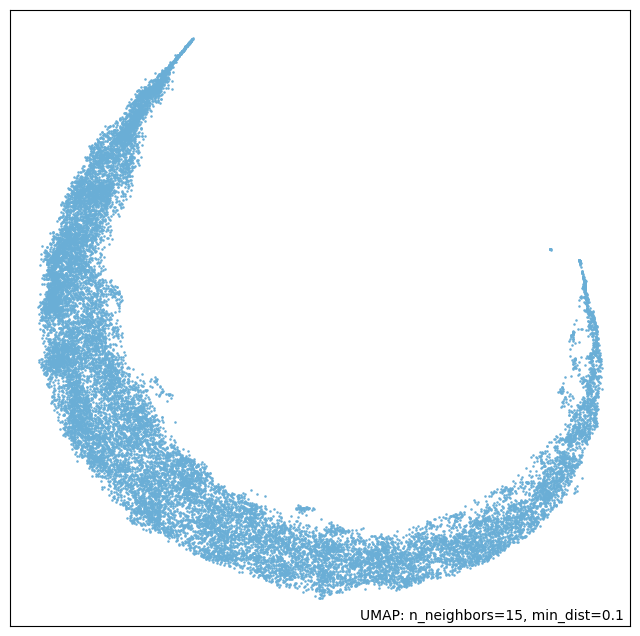

In [215]:
import umap.plot
mapper = umap.UMAP(metric='euclidean', random_state=42).fit(expr_gen)
umap.plot.points(mapper, theme = 'blue')

In [216]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=100,
    random_state=42,
).fit_transform(expr_gen)

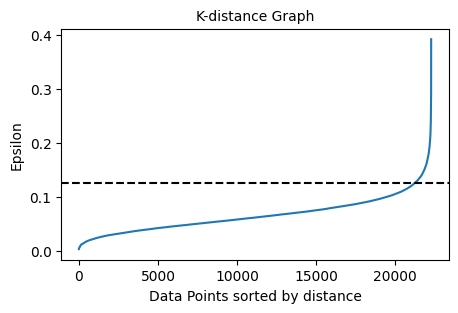

In [231]:
#@title Estimando hiperparámetros de DBSCAN
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(clusterable_embedding)
distances, indices = nbrs.kneighbors(clusterable_embedding)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(5,3))
plt.plot(distances)
plt.axhline(y = 0.125, color = 'black', linestyle = '--')
plt.title('K-distance Graph',fontsize=10)
plt.xlabel('Data Points sorted by distance',fontsize=10)
plt.ylabel('Epsilon',fontsize=10)
plt.show()

In [244]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.125, min_samples = 9)
model = dbscan.fit(clusterable_embedding)
prediction = dbscan.fit_predict(clusterable_embedding)

In [245]:
labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Número de clusters: %d" % n_clusters_)
print("Número de puntos de ruido: %d" % n_noise_)

Número de clusters: 106
Número de puntos de ruido: 5452


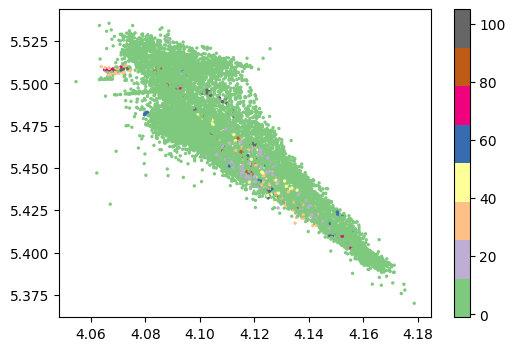

In [248]:
plt.figure(figsize = (6,4))
plt.scatter(clusterable_embedding[:,72], clusterable_embedding[:,25], 
            c = prediction,
            cmap = 'Accent',
            s = 2)
plt.colorbar()
plt.show()

## Principal Component Analysis

In [239]:
from sklearn.preprocessing import StandardScaler
expr_gen = gen.iloc[:,1:]
expr_gen = expr_gen.T

scaler = StandardScaler()
datos_estandarizados = scaler.fit_transform(expr_gen)

In [249]:
from sklearn.decomposition import PCA

n_components = 0.99

pca = PCA(n_components = n_components)
pca_comp = pca.fit_transform(datos_estandarizados)

In [ ]:
#pca.explained_variance_ratio_

In [251]:
dbscan = DBSCAN()
model = dbscan.fit(pca_comp)
prediction = dbscan.fit_predict(pca_comp)

In [252]:
labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Número de clusters: %d" % n_clusters_)
print("Número de puntos de ruido: %d" % n_noise_)

Número de clusters: 0
Número de puntos de ruido: 22283


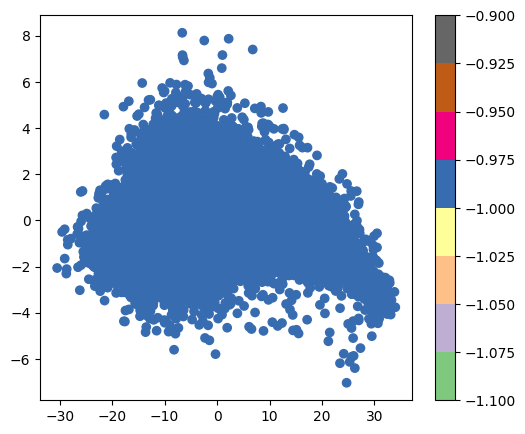

In [253]:
plt.figure(figsize = (6,5))
plt.scatter(pca_comp[:,0], pca_comp[:,1],
            c = prediction, cmap = 'Accent')
plt.colorbar()
plt.show()

* PCA inverso para descrubrir los genes